In [21]:
import duckdb
import pyarrow.dataset as ds
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

In [50]:
dataset = ds.dataset("data/status", format="parquet", partitioning="hive")
con = duckdb.connect()
con = con.register("status", dataset)

## Mean values per stations

In [ ]:
df_query = f"""select
        station_id,
        hour,
        num_bikes_available,
        num_bikes_disabled,
        num_docks_available,
        num_docks_disabled,
        status,
        make_timestamp(year, month, day, hour, minute, 0.0) as ts,
    from
        status
    where
        year::int = 2022
        AND month::int = 10 and
        status = 'IN_SERVICE'
"""
dataset_df = con.execute(df_query).df()

In [ ]:
dataset_df["bikes_available"] = (dataset_df["num_bikes_available"]>0).astype(int)

In [10]:
station_means = dataset_df.groupby("station_id").mean()
pd.concat([station_means.min(), station_means.max(), station_means.mean(), station_means.std()], axis=1).set_axis(["min", "max", "mean", "std"], axis=1)

/tmp/ipykernel_31289/2515545687.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  station_means = dataset_df.groupby("station_id").mean()


,min,max,mean,std
hour,11.500573,11.520399,11.500635,0.001112
num_bikes_available,1.216640,24.797515,7.240725,4.132119
num_bikes_disabled,0.073561,2.759027,1.034903,0.529289
num_docks_available,1.172737,25.907430,9.689012,4.884538
num_docks_disabled,0.000000,0.113106,0.002468,0.009902
bikes_available,0.547622,1.000000,0.913322,0.083520


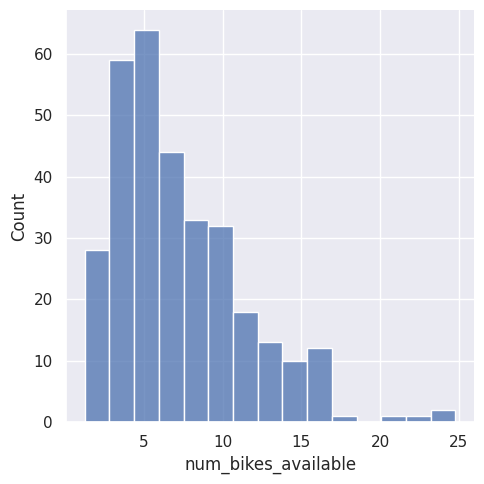

In [12]:
sns.displot(station_means, x="num_bikes_available")

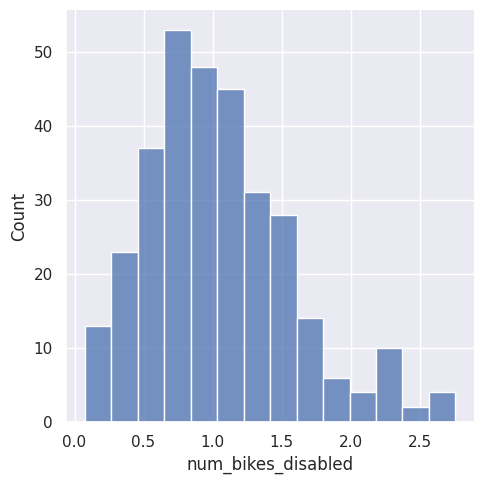

In [13]:
sns.displot(station_means, x="num_bikes_disabled")

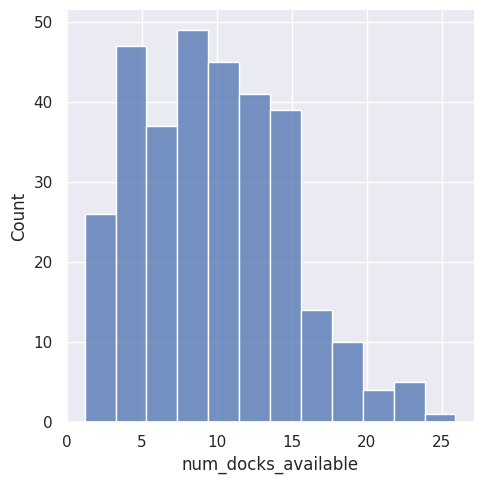

In [14]:
sns.displot(station_means, x="num_docks_available")

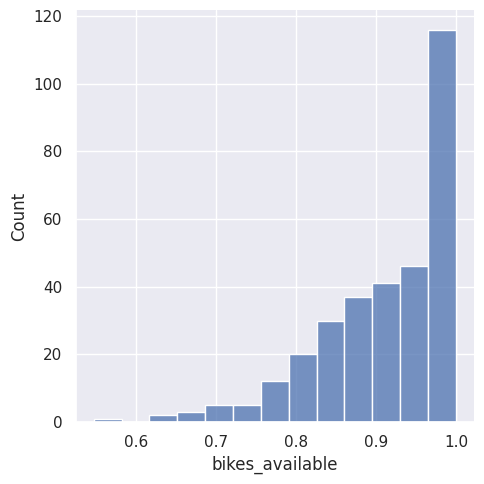

In [16]:
sns.displot(station_means, x="bikes_available")

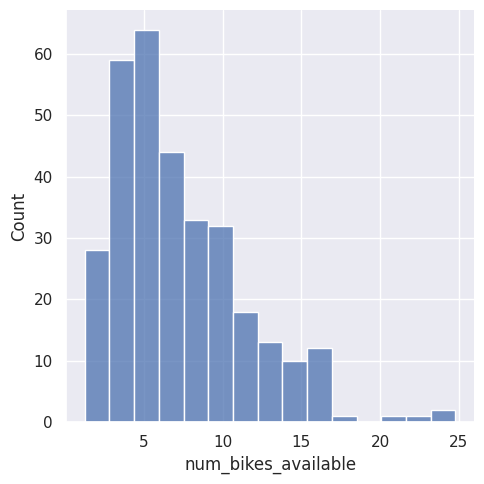

In [49]:
sns.displot(station_means, x="num_bikes_available")

## Empty stations percentage per hour

In [ ]:
df_query = f"""select day::int as day, hour::int as hour, avg((num_bikes_available = 0)::int) * 100 as perc_empty
        FROM status
        WHERE year::int = 2022
        AND month::int = 10
        AND status = 'IN_SERVICE'
        GROUP BY 1, 2
        ORDER BY 1 asc, 2 asc
"""
dataset_df = con.execute(df_query).df()

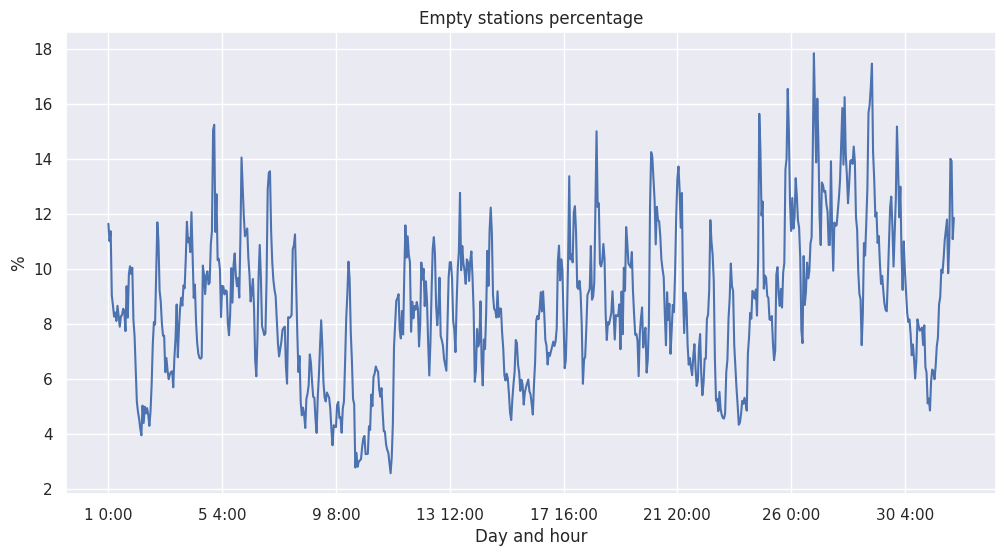

In [ ]:
hist = dataset_df
hist["date"] = hist.apply(lambda x: f"{int(x.day)} {int(x.hour)}:00", axis=1)
hist.set_index("date", inplace=True)
plt.figure(figsize=(12,6))
hist.perc_empty.plot(kind="line")
plt.ylabel("%")
plt.xlabel("Day and hour")
plt.title("Empty stations percentage")
plt.show()

In [ ]:
station_ids = con.execute("""select distinct(station_id) from status  WHERE year::int = 2022
        AND month::int = 10
        AND status = 'IN_SERVICE'""").df()["station_id"].values
len(station_ids)

318

In [ ]:
random.seed(42)
df_query = f"""select day::int as day, hour::int as hour, station_id::string as station_id, avg((num_bikes_available = 0)::int) * 100 as perc_empty
        FROM status
        WHERE year::int = 2022
        AND month::int = 10
        AND status = 'IN_SERVICE'
        AND station_id IN ({",".join(str(rid) for rid in random.sample(list(station_ids), k=5))})
        GROUP BY 1, 2, 3
        ORDER BY 1 asc, 2 asc
"""
dataset_df = con.execute(df_query).df()

<AxesSubplot: xlabel='date', ylabel='perc_empty'>

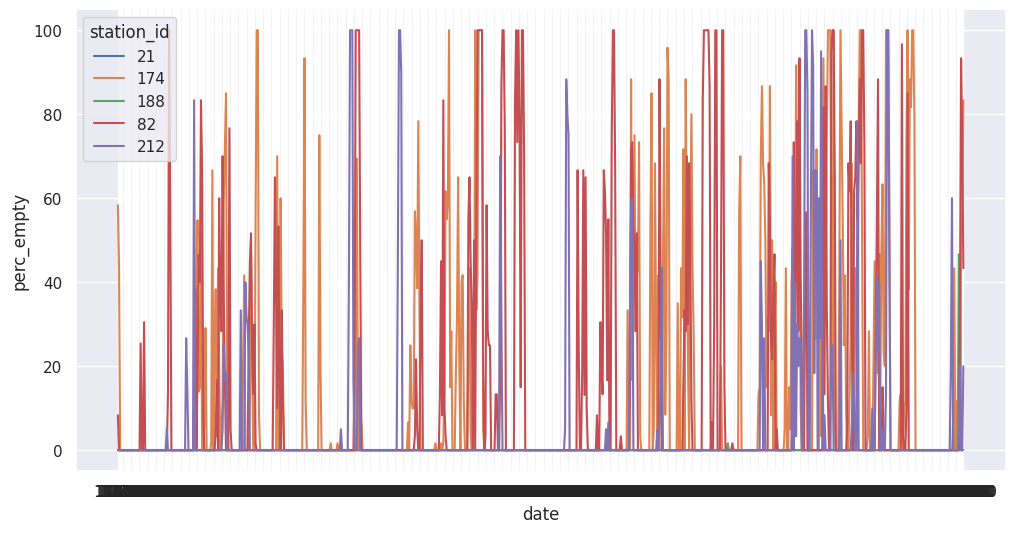

In [ ]:
hist = dataset_df
hist["date"] = hist.apply(lambda x: f"{int(x.day)} {int(x.hour)}:00", axis=1)
hist.set_index("date", inplace=True)
plt.figure(figsize=(12,6))
sns.lineplot(hist,x="date", y="perc_empty", hue="station_id")